In [1]:
#import all the necessary packages.

from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import math
import time
import re
import os
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity  
from sklearn.metrics import pairwise_distances
from matplotlib import gridspec
from scipy.sparse import hstack
import plotly
import plotly.figure_factory as ff
from plotly.graph_objs import Scatter, Layout

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

from xgboost import plot_importance
import numpy as np
from sklearn.metrics import confusion_matrix

plotly.offline.init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")

C:\Users\MERCER\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning:

calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.



# Load All Train Dataset

# Load train.csv

In [2]:
train = pd.read_csv("train.csv")
print("Shape of train data", train.shape)
train.head(3)

Shape of train data (78369, 5)


,id,campaign_id,coupon_id,customer_id,redemption_status
0,1,13,27,1053,0
1,2,13,116,48,0
2,6,9,635,205,0


In [3]:
train.isnull().sum()

id                   0
campaign_id          0
coupon_id            0
customer_id          0
redemption_status    0
dtype: int64

### Train Data Have no null values

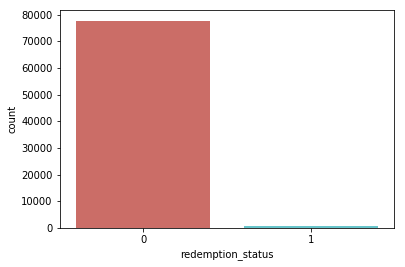

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(x='redemption_status',data=train, palette='hls')
plt.show();

In [5]:
train.redemption_status.value_counts()

0    77640
1      729
Name: redemption_status, dtype: int64

It is highly imbalance dataset having only 0.9 % have 1 and rest have not redeem coupon

In [6]:
train.describe()

,id,campaign_id,coupon_id,customer_id,redemption_status
count,78369.000000,78369.000000,78369.000000,78369.000000,78369.000000
mean,64347.975449,13.974441,566.363243,787.451888,0.009302
std,37126.440855,8.019215,329.966054,456.811339,0.095999
min,1.000000,1.000000,1.000000,1.000000,0.000000
25%,32260.000000,8.000000,280.000000,399.000000,0.000000
50%,64318.000000,13.000000,597.000000,781.000000,0.000000
75%,96577.000000,13.000000,857.000000,1190.000000,0.000000
max,128595.000000,30.000000,1115.000000,1582.000000,1.000000


In [7]:
train.dtypes

id                   int64
campaign_id          int64
coupon_id            int64
customer_id          int64
redemption_status    int64
dtype: object

In [8]:
#Deduplication of entries
train = train.drop_duplicates(subset=train.columns, keep='first', inplace=False)
train.shape

(78369, 5)

# Load campaign_data.csv

In [9]:
campaign_data = pd.read_csv("campaign_data.csv")
print("Shape of campaign_data" , campaign_data.shape)
campaign_data.head(3)

Shape of campaign_data (28, 4)


,campaign_id,campaign_type,start_date,end_date
0,24,Y,21/10/13,20/12/13
1,25,Y,21/10/13,22/11/13
2,20,Y,07/09/13,16/11/13


In [10]:
len(train.campaign_id.unique()),len(campaign_data.campaign_id.unique())

(18, 28)

### Out of 28 campaign_id train data have 18 campaign_id

In [11]:
print("Number of campaign_id common in train & campaign_data  ",train['campaign_id'].isin(campaign_data['campaign_id']).value_counts())

Number of campaign_id common in train & campaign_data   True    78369
Name: campaign_id, dtype: int64


In [12]:
campaign_data.isnull().sum()

campaign_id      0
campaign_type    0
start_date       0
end_date         0
dtype: int64

In [13]:
campaign_data.dtypes

campaign_id       int64
campaign_type    object
start_date       object
end_date         object
dtype: object

In [14]:
campaign_data_orig = campaign_data.copy()

In [15]:
# dateTime is object so convert it in datetime
from datetime import datetime 
campaign_data['start_date'] = pd.to_datetime(campaign_data.start_date,format='%d/%m/%y')
campaign_data_orig['start_date'] = pd.to_datetime(campaign_data_orig.start_date,format='%d/%m/%y')


campaign_data['end_date'] = pd.to_datetime(campaign_data.end_date,format='%d/%m/%y') 
campaign_data_orig['end_date'] = pd.to_datetime(campaign_data_orig.end_date,format='%d/%m/%y') 



In [16]:
campaign_data.dtypes

campaign_id               int64
campaign_type            object
start_date       datetime64[ns]
end_date         datetime64[ns]
dtype: object

In [17]:
# We made some hypothesis for the effect of hour, day, month and year on the passenger count. So, let’s extract the year, month, day and hour from the Datetime to validate our hypothesis.

for i in (campaign_data,campaign_data_orig):
    i['start_year']=i.start_date.dt.year 
    i['start_month']=i.start_date.dt.month 
    i['start_day']=i.start_date.dt.day
    
    
    i['end_year']=i.end_date.dt.year 
    i['end_month']=i.end_date.dt.month 
    i['end_day']=i.end_date.dt.day

    
    

In [18]:
campaign_data['start_day_of_week']=campaign_data['start_date'].dt.dayofweek 
temp = campaign_data['start_day_of_week']


campaign_data_orig['start_day_of_week']=campaign_data_orig['start_date'].dt.dayofweek 
temp = campaign_data_orig['start_day_of_week']

campaign_data['end_day_of_week']=campaign_data['end_date'].dt.dayofweek 
temp = campaign_data['end_day_of_week']

campaign_data_orig['end_day_of_week']=campaign_data_orig['end_date'].dt.dayofweek 
temp = campaign_data_orig['end_day_of_week']

In [19]:
def applyer(row):
    if row.dayofweek == 5 or row.dayofweek == 6:
        return 1
    else:
        return 0 
temp2 = campaign_data['start_date'].apply(applyer) 
campaign_data['start_weekend']=temp2

temp2 = campaign_data['end_date'].apply(applyer) 
campaign_data['end_weekend']=temp2



temp2 = campaign_data_orig['start_date'].apply(applyer) 
campaign_data_orig['start_weekend']=temp2

temp2 = campaign_data_orig['end_date'].apply(applyer) 
campaign_data_orig['end_weekend']=temp2




In [20]:
campaign_data.head(3)

,campaign_id,campaign_type,start_date,end_date,start_year,start_month,start_day,end_year,end_month,end_day,start_day_of_week,end_day_of_week,start_weekend,end_weekend
0,24,Y,2013-10-21,2013-12-20,2013,10,21,2013,12,20,0,4,0,0
1,25,Y,2013-10-21,2013-11-22,2013,10,21,2013,11,22,0,4,0,0
2,20,Y,2013-09-07,2013-11-16,2013,9,7,2013,11,16,5,5,1,1


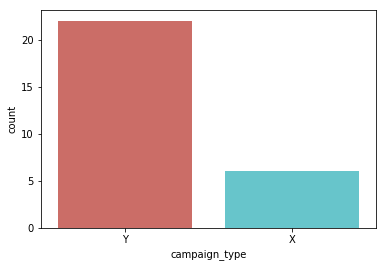

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(x='campaign_type',data=campaign_data, palette='hls')
plt.show();

In [22]:
campaign_data.describe()

,campaign_id,start_year,start_month,start_day,end_year,end_month,end_day,start_day_of_week,end_day_of_week,start_weekend,end_weekend
count,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000
mean,15.571429,2012.714286,7.000000,15.964286,2012.857143,6.678571,15.392857,2.000000,4.107143,0.357143,0.107143
std,9.118271,0.460044,3.610684,7.021038,0.356348,3.801107,8.161968,2.553139,0.314970,0.487950,0.314970
min,1.000000,2012.000000,1.000000,2.000000,2012.000000,1.000000,1.000000,0.000000,4.000000,0.000000,0.000000
25%,7.750000,2012.000000,4.000000,10.750000,2013.000000,3.000000,8.000000,0.000000,4.000000,0.000000,0.000000
50%,16.500000,2013.000000,8.000000,16.000000,2013.000000,7.500000,16.000000,0.000000,4.000000,0.000000,0.000000
75%,23.250000,2013.000000,10.000000,21.250000,2013.000000,10.000000,20.250000,5.000000,4.000000,1.000000,0.000000
max,30.000000,2013.000000,12.000000,29.000000,2013.000000,12.000000,30.000000,6.000000,5.000000,1.000000,1.000000


In [23]:
campaign_data.dtypes

campaign_id                   int64
campaign_type                object
start_date           datetime64[ns]
end_date             datetime64[ns]
start_year                    int64
start_month                   int64
start_day                     int64
end_year                      int64
end_month                     int64
end_day                       int64
start_day_of_week             int64
end_day_of_week               int64
start_weekend                 int64
end_weekend                   int64
dtype: object

In [24]:
#Deduplication of entries
campaign_data = campaign_data.drop_duplicates(subset=campaign_data.columns, keep='first', inplace=False)
campaign_data.shape

(28, 14)

# Load coupon_item_mapping.csv

In [25]:
coupon_item_mapping = pd.read_csv("coupon_item_mapping.csv")
print("Shape of coupon_item_mapping", coupon_item_mapping.shape)
coupon_item_mapping.head(3)

Shape of coupon_item_mapping (92663, 2)


,coupon_id,item_id
0,105,37
1,107,75
2,494,76


In [26]:
print("Unique number of coupon_id in train ",len(train.coupon_id.unique()))
print("Unique number of coupon_id in coupon_item_mapping ",len(coupon_item_mapping.coupon_id.unique()))

Unique number of coupon_id in train  866
Unique number of coupon_id in coupon_item_mapping  1116


In [27]:
coupon_item_mapping.describe()

,coupon_id,item_id
count,92663.000000,92663.000000
mean,155.967387,36508.613071
std,282.991720,21131.312716
min,1.000000,1.000000
25%,22.000000,18255.500000
50%,30.000000,37955.000000
75%,42.000000,54191.500000
max,1116.000000,74061.000000


In [28]:
coupon_item_mapping.dtypes

coupon_id    int64
item_id      int64
dtype: object

### Out of 1116 unique coupon_id in coupon_item_mapping train have 866 unique coupon id

In [29]:
print("Number of coupon_id common in train & coupon_item_mapping  ",train['coupon_id'].isin(coupon_item_mapping['coupon_id']).value_counts())

Number of coupon_id common in train & coupon_item_mapping   True    78369
Name: coupon_id, dtype: int64


In [30]:
#Deduplication of entries
coupon_item_mapping = coupon_item_mapping.drop_duplicates(subset=coupon_item_mapping.columns, keep='first', inplace=False)
coupon_item_mapping.shape

(92663, 2)

# Load item_data.csv

In [31]:
item_data = pd.read_csv("item_data.csv")
print("shape of item_data",item_data.shape)
item_data.head(3)

shape of item_data (74066, 4)


,item_id,brand,brand_type,category
0,1,1,Established,Grocery
1,2,1,Established,Miscellaneous
2,3,56,Local,Bakery


In [32]:
item_data.category.value_counts()

Grocery                   32448
Pharmaceutical            24471
Natural Products           2533
Dairy, Juices & Snacks     2425
Skin & Hair Care           2244
Meat                       2080
Packaged Meat              1966
Prepared Food              1880
Bakery                     1679
Seafood                     728
Flowers & Plants            664
Miscellaneous               385
Alcohol                     303
Garden                      102
Restauarant                  78
Salads                       40
Travel                       19
Fuel                         14
Vegetables (cut)              7
Name: category, dtype: int64

In [33]:
print("Unique number of coupon_id in coupon_item_mapping ",len(coupon_item_mapping.item_id.unique()))

print("Unique number of coupon_id in item_data ",len(item_data.item_id.unique()))

Unique number of coupon_id in coupon_item_mapping  36289
Unique number of coupon_id in item_data  74066


### Out of 74066 unique item_id in item_data coupon_item_mapping have 36289 unique item_id 

In [36]:
print("Number of item_id common in coupon_item_mapping & customer_transaction_data  ",coupon_item_mapping['item_id'].isin(customer_transaction_data['item_id']).value_counts())

Number of item_id common in coupon_item_mapping & customer_transaction_data   True     92655
False        8
Name: item_id, dtype: int64


In [37]:
print("Number of item_id common in coupon_item_mapping & item_data  ",coupon_item_mapping['item_id'].isin(item_data['item_id']).value_counts())

Number of item_id common in coupon_item_mapping & item_data   True    92663
Name: item_id, dtype: int64


In [38]:
print("Number of item_id common in item_data & customer_transaction_data  ",item_data['item_id'].isin(customer_transaction_data['item_id']).value_counts())

Number of item_id common in item_data & customer_transaction_data   True     74063
False        3
Name: item_id, dtype: int64


In [39]:
item_data.describe()

,item_id,brand
count,74066.000000,74066.000000
mean,37033.500000,1485.560055
std,21381.156856,1537.385673
min,1.000000,1.000000
25%,18517.250000,278.000000
50%,37033.500000,978.000000
75%,55549.750000,2013.000000
max,74066.000000,5528.000000


In [40]:
item_data.dtypes

item_id        int64
brand          int64
brand_type    object
category      object
dtype: object

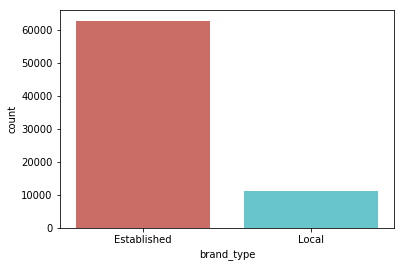

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(x='brand_type',data=item_data, palette='hls')
plt.show();

In [42]:
#Deduplication of entries
item_data = item_data.drop_duplicates(subset=item_data.columns, keep='first', inplace=False)
item_data.shape

(74066, 4)

# Load customer_transaction_data.csv

In [35]:
customer_transaction_data = pd.read_csv("customer_transaction_data.csv")
print("shape of customer_transaction_data is : ",customer_transaction_data.shape)
customer_transaction_data.head(3)

shape of customer_transaction_data is :  (1324566, 7)


,date,customer_id,item_id,quantity,selling_price,other_discount,coupon_discount
0,2012-01-02,1501,26830,1,35.26,-10.69,0.0
1,2012-01-02,1501,54253,1,53.43,-13.89,0.0
2,2012-01-02,1501,31962,1,106.50,-14.25,0.0


In [43]:
#Deduplication of entries
customer_transaction_data = customer_transaction_data.drop_duplicates(subset=customer_transaction_data.columns, keep='first', inplace=False)
customer_transaction_data.shape

(1321650, 7)

In [44]:
 customer_transaction_data.isnull().sum()

date               0
customer_id        0
item_id            0
quantity           0
selling_price      0
other_discount     0
coupon_discount    0
dtype: int64

### Have no null values

In [47]:
print("Unique number of customer_id in train ",len(train.customer_id.unique()))
print("Unique number of customer_id in customer_demographics ",len(customer_demographics.customer_id.unique()))
print("Unique number of customer_id in customer_transaction_data ",len(customer_transaction_data.customer_id.unique()))

Unique number of customer_id in train  1428
Unique number of customer_id in customer_demographics  760
Unique number of customer_id in customer_transaction_data  1582


In [48]:
print("Unique number of item_id in item_data ",len(item_data.item_id.unique()))
print("Unique number of item_id in coupon_item_mapping ",len(coupon_item_mapping.item_id.unique()))
print("Unique number of item_id in customer_transaction_data ",len(customer_transaction_data.item_id.unique()))

Unique number of item_id in item_data  74066
Unique number of item_id in coupon_item_mapping  36289
Unique number of item_id in customer_transaction_data  74063


In [49]:
print("Number of customer_id common in train & customer_demographics  ",train['customer_id'].isin(customer_demographics['customer_id']).value_counts())

Number of customer_id common in train & customer_demographics   True     43661
False    34708
Name: customer_id, dtype: int64


In [50]:
print("Number of customer_id common in train & customer_transaction_data  ",train['customer_id'].isin(customer_transaction_data['customer_id']).value_counts())

Number of customer_id common in train & customer_transaction_data   True    78369
Name: customer_id, dtype: int64


In [51]:
print("Number of customer_id common in customer_demographics & customer_transaction_data  ",customer_demographics['customer_id'].isin(customer_transaction_data['customer_id']).value_counts())

Number of customer_id common in customer_demographics & customer_transaction_data   True    760
Name: customer_id, dtype: int64


In [52]:
customer_transaction_data.describe()

,customer_id,item_id,quantity,selling_price,other_discount,coupon_discount
count,1.321650e+06,1.321650e+06,1.321650e+06,1.321650e+06,1.321650e+06,1.321650e+06
mean,8.039203e+02,2.951725e+04,1.308889e+02,1.145666e+02,-1.774348e+01,-5.748105e-01
std,4.572730e+02,1.790728e+04,1.312459e+03,1.527346e+02,3.782111e+01,7.007641e+00
min,1.000000e+00,1.000000e+00,1.000000e+00,3.600000e-01,-3.120310e+03,-1.992230e+03
25%,4.180000e+02,1.468300e+04,1.000000e+00,4.951000e+01,-2.315000e+01,0.000000e+00
50%,8.010000e+02,2.659400e+04,1.000000e+00,7.801000e+01,-1.780000e+00,0.000000e+00
75%,1.197000e+03,4.240700e+04,1.000000e+00,1.243100e+02,0.000000e+00,0.000000e+00
max,1.582000e+03,7.406600e+04,8.963800e+04,1.780964e+04,0.000000e+00,0.000000e+00


In [53]:
customer_transaction_data.dtypes

date                object
customer_id          int64
item_id              int64
quantity             int64
selling_price      float64
other_discount     float64
coupon_discount    float64
dtype: object

In [54]:
# Convert DOT to Datatime format and generate year month etc features

In [55]:
customer_transaction_data_orig = customer_transaction_data.copy()

In [56]:
# dateTime is object so convert it in datetime
from datetime import datetime 
customer_transaction_data['date'] = pd.to_datetime(customer_transaction_data.date,format='%Y-%m-%d')
customer_transaction_data_orig['date'] = pd.to_datetime(customer_transaction_data_orig.date,format='%Y-%m-%d')





In [57]:
customer_transaction_data.dtypes

date               datetime64[ns]
customer_id                 int64
item_id                     int64
quantity                    int64
selling_price             float64
other_discount            float64
coupon_discount           float64
dtype: object

In [58]:
# We made some hypothesis for the effect of hour, day, month and year on the passenger count. So, let’s extract the year, month, day and hour from the Datetime to validate our hypothesis.

for i in (customer_transaction_data,customer_transaction_data_orig):
    i['dot_year']=i.date.dt.year 
    i['dot_month']=i.date.dt.month 
    i['dot_day']=i.date.dt.day
    

    
    

In [59]:
customer_transaction_data['dot_day_of_week']=customer_transaction_data['date'].dt.dayofweek 
temp = customer_transaction_data['dot_day_of_week']


customer_transaction_data_orig['dot_day_of_week']=customer_transaction_data_orig['date'].dt.dayofweek 
temp = customer_transaction_data_orig['dot_day_of_week']



In [60]:
temp2 = customer_transaction_data['date'].apply(applyer) 
customer_transaction_data['dot_weekend']=temp2

temp2 = customer_transaction_data_orig['date'].apply(applyer) 
customer_transaction_data_orig['dot_weekend']=temp2

In [61]:
customer_transaction_data.head(3)

,date,customer_id,item_id,quantity,selling_price,other_discount,coupon_discount,dot_year,dot_month,dot_day,dot_day_of_week,dot_weekend
0,2012-01-02,1501,26830,1,35.26,-10.69,0.0,2012,1,2,0,0
1,2012-01-02,1501,54253,1,53.43,-13.89,0.0,2012,1,2,0,0
2,2012-01-02,1501,31962,1,106.50,-14.25,0.0,2012,1,2,0,0


In [62]:
customer_transaction_data.isnull().any().any()

False

# Load customer_demographics.csv

In [46]:
customer_demographics = pd.read_csv("customer_demographics.csv")
print("shape of customer_demographics",customer_demographics.shape)
customer_demographics.head(3)

shape of customer_demographics (760, 7)


,customer_id,age_range,marital_status,rented,family_size,no_of_children,income_bracket
0,1,70+,Married,0,2,NaN,4
1,6,46-55,Married,0,2,NaN,5
2,7,26-35,NaN,0,3,1,3


In [63]:
#Deduplication of entries
customer_demographics = customer_demographics.drop_duplicates(subset=customer_demographics.columns, keep='first', inplace=False)
customer_demographics.shape

(760, 7)

In [64]:
print("Unique number of customer_id in train ",len(train.customer_id.unique()))
print("Unique number of customer_id in customer_demographics ",len(customer_demographics.customer_id.unique()))
print("Unique number of customer_id in customer_transaction_data ",len(customer_transaction_data.customer_id.unique()))

Unique number of customer_id in train  1428
Unique number of customer_id in customer_demographics  760
Unique number of customer_id in customer_transaction_data  1582


In [65]:
 customer_demographics.isnull().sum()

customer_id         0
age_range           0
marital_status    329
rented              0
family_size         0
no_of_children    538
income_bracket      0
dtype: int64

In [66]:
customer_demographics.dtypes

customer_id        int64
age_range         object
marital_status    object
rented             int64
family_size       object
no_of_children    object
income_bracket     int64
dtype: object

In [67]:
customer_demographics.family_size.value_counts()

2     303
1     248
3     104
5+     57
4      48
Name: family_size, dtype: int64

In [68]:
customer_demographics.no_of_children.value_counts()

1     107
3+     60
2      55
Name: no_of_children, dtype: int64

In [69]:
customer_demographics.marital_status.value_counts()

Married    317
Single     114
Name: marital_status, dtype: int64

In [70]:
customer_demographics.age_range.value_counts()

46-55    271
36-45    187
26-35    130
70+       68
56-70     59
18-25     45
Name: age_range, dtype: int64

# Load Test Data

In [71]:
test = pd.read_csv("test.csv")
print("Shape Of Test Data : ",test.shape)
test.head(3)

Shape Of Test Data :  (50226, 4)


,id,campaign_id,coupon_id,customer_id
0,3,22,869,967
1,4,20,389,1566
2,5,22,981,510


In [72]:
test.isnull().any().any()

False

In [73]:
test.dtypes

id             int64
campaign_id    int64
coupon_id      int64
customer_id    int64
dtype: object

In [74]:
len(test.campaign_id.unique()),len(campaign_data.campaign_id.unique())


(10, 28)

In [75]:
print("Number of campaign_id common in test & campaign_data  ",test['campaign_id'].isin(campaign_data['campaign_id']).value_counts())

Number of campaign_id common in test & campaign_data   True    50226
Name: campaign_id, dtype: int64


In [76]:
print("Unique number of coupon_id in test ",len(test.coupon_id.unique()))
print("Unique number of coupon_id in coupon_item_mapping ",len(coupon_item_mapping.coupon_id.unique()))


Unique number of coupon_id in test  331
Unique number of coupon_id in coupon_item_mapping  1116


In [77]:
print("Number of coupon_id common in test & coupon_item_mapping  ",test['coupon_id'].isin(coupon_item_mapping['coupon_id']).value_counts())

Number of coupon_id common in test & coupon_item_mapping   True    50226
Name: coupon_id, dtype: int64


In [78]:
print("Unique number of customer_id in test ",len(test.customer_id.unique()))
print("Unique number of customer_id in customer_demographics ",len(customer_demographics.customer_id.unique()))
print("Unique number of customer_id in customer_transaction_data ",len(customer_transaction_data.customer_id.unique()))

Unique number of customer_id in test  1250
Unique number of customer_id in customer_demographics  760
Unique number of customer_id in customer_transaction_data  1582


In [79]:
print("Number of customer_id common in test & customer_demographics  ",test['customer_id'].isin(customer_demographics['customer_id']).value_counts())

Number of customer_id common in test & customer_demographics   True     30939
False    19287
Name: customer_id, dtype: int64


In [80]:
print("Number of customer_id common in test & customer_transaction_data  ",test['customer_id'].isin(customer_transaction_data['customer_id']).value_counts())

Number of customer_id common in test & customer_transaction_data   True    50226
Name: customer_id, dtype: int64


# Load Submission Data

In [81]:
submission = pd.read_csv("sample_submission.csv")
print("Shape Of submission Data : ",submission.shape)
submission.head(3)

Shape Of submission Data :  (50226, 2)


,id,redemption_status
0,3,0
1,4,0
2,5,0


# Merge Different Data According to above EDA

## Merge Train and Campaign Data on campaign id

In [82]:
train_campaign_data = train.merge(campaign_data,on = 'campaign_id',how = 'left')

print("Shape of train_campaign_data : ",train_campaign_data.shape)

train_campaign_data.head(3)

Shape of train_campaign_data :  (78369, 18)


,id,campaign_id,coupon_id,customer_id,redemption_status,campaign_type,start_date,end_date,start_year,start_month,start_day,end_year,end_month,end_day,start_day_of_week,end_day_of_week,start_weekend,end_weekend
0,1,13,27,1053,0,X,2013-05-19,2013-07-05,2013,5,19,2013,7,5,6,4,1,0
1,2,13,116,48,0,X,2013-05-19,2013-07-05,2013,5,19,2013,7,5,6,4,1,0
2,6,9,635,205,0,Y,2013-03-11,2013-04-12,2013,3,11,2013,4,12,0,4,0,0


In [83]:
print("Number of customer_id common in train_campaign_data & customer_demographics  ",train_campaign_data['customer_id'].isin(customer_transaction_data['customer_id']).value_counts())

Number of customer_id common in train_campaign_data & customer_demographics   True    78369
Name: customer_id, dtype: int64


## Merge Test and Campaign Data

In [84]:
test_campaign_data = test.merge(campaign_data,on = 'campaign_id',how = 'left')

print("Shape of test_campaign_data : ",test_campaign_data.shape)

test_campaign_data.head(3)

Shape of test_campaign_data :  (50226, 17)


,id,campaign_id,coupon_id,customer_id,campaign_type,start_date,end_date,start_year,start_month,start_day,end_year,end_month,end_day,start_day_of_week,end_day_of_week,start_weekend,end_weekend
0,3,22,869,967,X,2013-09-16,2013-10-18,2013,9,16,2013,10,18,0,4,0,0
1,4,20,389,1566,Y,2013-09-07,2013-11-16,2013,9,7,2013,11,16,5,5,1,1
2,5,22,981,510,X,2013-09-16,2013-10-18,2013,9,16,2013,10,18,0,4,0,0


In [85]:
test_campaign_data.isnull().any().any()

False

## Merge CIM & item_data

In [86]:
cim_item_data = coupon_item_mapping.merge(item_data,on = 'item_id',how = 'left')

print("Shape of cim_item_data : ",cim_item_data.shape)

cim_item_data.head(3)


Shape of cim_item_data :  (92663, 5)


,coupon_id,item_id,brand,brand_type,category
0,105,37,56,Local,Grocery
1,107,75,56,Local,Grocery
2,494,76,209,Established,Grocery


In [87]:
cim_item_data.isnull().any().any()

False

## Merge cim_item_data and train_campaign_data

In [88]:
train_cim_item_data = train_campaign_data.merge(cim_item_data,on = 'coupon_id',how = 'left')

print("Shape of train_cim_item_data : ",train_cim_item_data.shape)

train_cim_item_data.head(3)


Shape of train_cim_item_data :  (6420694, 22)


,id,campaign_id,coupon_id,customer_id,redemption_status,campaign_type,start_date,end_date,start_year,start_month,...,end_month,end_day,start_day_of_week,end_day_of_week,start_weekend,end_weekend,item_id,brand,brand_type,category
0,1,13,27,1053,0,X,2013-05-19,2013-07-05,2013,5,...,7,5,6,4,1,0,24775,1636,Established,Grocery
1,1,13,27,1053,0,X,2013-05-19,2013-07-05,2013,5,...,7,5,6,4,1,0,14958,1636,Established,Grocery
2,1,13,27,1053,0,X,2013-05-19,2013-07-05,2013,5,...,7,5,6,4,1,0,40431,1636,Established,Grocery


In [89]:
#Deduplication of entries
train_cim_item_data = train_cim_item_data.drop(columns=["campaign_id","coupon_id","item_id"], inplace=False)
train_cim_item_data.shape

(6420694, 19)

In [90]:
#Deduplication of entries
train_cim_item_data = train_cim_item_data.drop_duplicates(subset=train_cim_item_data.columns, keep='first', inplace=False)
train_cim_item_data.shape

(580471, 19)

In [91]:
train_cim_item_data.isnull().any().any()

False

In [92]:
train_cim_item_data.to_csv("train_cim_item_data_drop.csv")

## Merge test_campaign_data & cim_item_data

In [93]:
test_cim_item_data = test_campaign_data.merge(cim_item_data,on = 'coupon_id',how = 'left')

print("Shape of test_cim_item_data : ",test_cim_item_data.shape)

test_cim_item_data.head(3)


Shape of test_cim_item_data :  (5421801, 21)


,id,campaign_id,coupon_id,customer_id,campaign_type,start_date,end_date,start_year,start_month,start_day,...,end_month,end_day,start_day_of_week,end_day_of_week,start_weekend,end_weekend,item_id,brand,brand_type,category
0,3,22,869,967,X,2013-09-16,2013-10-18,2013,9,16,...,10,18,0,4,0,0,1033,1075,Established,Grocery
1,3,22,869,967,X,2013-09-16,2013-10-18,2013,9,16,...,10,18,0,4,0,0,1067,1075,Established,Grocery
2,3,22,869,967,X,2013-09-16,2013-10-18,2013,9,16,...,10,18,0,4,0,0,1084,1075,Established,Grocery


In [94]:
#Deduplication of entries
test_cim_item_data = test_cim_item_data.drop(columns=["campaign_id","coupon_id","item_id"], inplace=False)
test_cim_item_data.shape

(5421801, 18)

In [95]:
test_cim_item_data.head(3)

,id,customer_id,campaign_type,start_date,end_date,start_year,start_month,start_day,end_year,end_month,end_day,start_day_of_week,end_day_of_week,start_weekend,end_weekend,brand,brand_type,category
0,3,967,X,2013-09-16,2013-10-18,2013,9,16,2013,10,18,0,4,0,0,1075,Established,Grocery
1,3,967,X,2013-09-16,2013-10-18,2013,9,16,2013,10,18,0,4,0,0,1075,Established,Grocery
2,3,967,X,2013-09-16,2013-10-18,2013,9,16,2013,10,18,0,4,0,0,1075,Established,Grocery


In [96]:
#Deduplication of entries
test_cim_item_data = test_cim_item_data.drop_duplicates(subset=test_cim_item_data.columns, keep='first', inplace=False)
test_cim_item_data.shape

(401012, 18)

In [97]:
test_cim_item_data.isnull().any().any()

False

In [98]:
test_cim_item_data.to_csv("test_cim_item_data_drop.csv")

## Merge train_cim_item_data with CTD

In [99]:
train_cim_item_data.shape

(580471, 19)

In [27]:
df1 = pd.read_csv("train_cim_item_data_drop.csv")
df2 = pd.read_csv("customer_transaction_data_new.csv")
#df2_key = df2.Colname2

# creating a empty bucket to save result
#df_result = pd.DataFrame(columns=(df1.columns.append(df2.columns)).unique())
#df_result.to_hdf("df3.h5",index_label=False,key='df2')

# save data which only appear in df1 # sorry I was doing left join here. no need to run below two line.
# df_result = df1[df1.Colname1.isin(df2.Colname2)!=True]
# df_result.to_csv("df3.csv",index_label=False, mode="a")

# deleting df2 to save memory
#del(df2)

def preprocess(x):
    df2=pd.merge(df1,x,on = 'customer_id',how = 'left')
    df2.to_hdf("df3.h5",mode="a",header=False,index=False,key='df2')

reader = pd.read_csv("customer_transaction_data_new.csv", chunksize=30000) # chunksize depends with you colsize

[preprocess(r) for r in reader]

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [100]:
train_cim_ctd_item_data_drop = pd.read_hdf("df3.h5",key = "df2" )
print("Shape of train_cim_ctd_item_data_drop is : ",train_cim_ctd_item_data_drop.shape)
train_cim_ctd_item_data_drop.head(3)

Shape of train_cim_ctd_item_data_drop is :  (2662985, 32)


,Unnamed: 0_x,id,customer_id,redemption_status,campaign_type,start_date,end_date,start_year,start_month,start_day,...,item_id,quantity,selling_price,other_discount,coupon_discount,dot_year,dot_month,dot_day,dot_day_of_week,dot_weekend
0,0,1,1053,0,X,2013-05-19,2013-07-05,2013,5,19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,14,1,1053,0,X,2013-05-19,2013-07-05,2013,5,19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,125,2,48,0,X,2013-05-19,2013-07-05,2013,5,19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [101]:
#Deduplication of entries
train_cim_ctd_item_data_drop = train_cim_ctd_item_data_drop.drop(columns=["Unnamed: 0_x","Unnamed: 0_y"], inplace=False)
train_cim_ctd_item_data_drop.shape

(2662985, 30)

In [102]:
#Deduplication of entries
train_cim_ctd_item_data_drop = train_cim_ctd_item_data_drop.drop_duplicates(subset=train_cim_ctd_item_data_drop.columns, keep='first', inplace=False)
train_cim_ctd_item_data_drop.shape

(2656604, 30)

In [103]:
#Deduplication of entries
train_cim_ctd_item_data_drop = train_cim_ctd_item_data_drop.drop(columns=["item_id"], inplace=False)

#Deduplication of entries
train_cim_ctd_item_data_drop = train_cim_ctd_item_data_drop.drop_duplicates(subset=train_cim_ctd_item_data_drop.columns, keep='first', inplace=False)
train_cim_ctd_item_data_drop.shape

(2358061, 29)

## Merge CTD and test_cim_item_data

In [123]:
df5 = pd.read_csv("test_cim_item_data_drop.csv")



def preprocess(x):
    df6=pd.merge(df5,x,on = 'customer_id',how = 'left')
    df6.to_hdf("df_test_merge.h5",mode="a",header=False,index=False,key='df4')

reader = pd.read_csv("customer_transaction_data_new.csv", chunksize=30000) # chunksize depends with you colsize

[preprocess(r) for r in reader]

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [105]:
test_cim_ctd_item_data_drop = pd.read_hdf("df_test_merge.h5",key = "df4" )
print("Shape of test_cim_ctd_item_data_drop is : ",test_cim_ctd_item_data_drop.shape)
test_cim_ctd_item_data_drop.head(3)

Shape of test_cim_ctd_item_data_drop is :  (1829217, 31)


,Unnamed: 0_x,id,customer_id,campaign_type,start_date,end_date,start_year,start_month,start_day,end_year,...,item_id,quantity,selling_price,other_discount,coupon_discount,dot_year,dot_month,dot_day,dot_day_of_week,dot_weekend
0,0,3,967,X,2013-09-16,2013-10-18,2013,9,16,2013,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,72,4,1566,Y,2013-09-07,2013-11-16,2013,9,7,2013,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,94,4,1566,Y,2013-09-07,2013-11-16,2013,9,7,2013,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [106]:
#Deduplication of entries
test_cim_ctd_item_data_drop = test_cim_ctd_item_data_drop.drop(columns=["Unnamed: 0_x","Unnamed: 0_y"], inplace=False)
test_cim_ctd_item_data_drop.shape

(1829217, 29)

In [107]:
test_cim_ctd_item_data_drop = test_cim_ctd_item_data_drop.drop_duplicates(subset=test_cim_ctd_item_data_drop.columns, keep='first', inplace=False)
test_cim_ctd_item_data_drop.shape

(1821612, 29)

In [108]:
#Deduplication of entries
test_cim_ctd_item_data_drop = test_cim_ctd_item_data_drop.drop(columns=["item_id"], inplace=False)

#Deduplication of entries
test_cim_ctd_item_data_drop = test_cim_ctd_item_data_drop.drop_duplicates(subset=test_cim_ctd_item_data_drop.columns, keep='first', inplace=False)
test_cim_ctd_item_data_drop.shape

(1633590, 28)

## Merge CD and train_cim_ctd_cd_item_data_drop

In [109]:
train_cim_ctd_cd_item_data_drop = train_cim_ctd_item_data_drop.merge(customer_demographics,on = 'customer_id',how = 'left')

print("Shape of train_cim_ctd_cd_item_data_drop : ",train_cim_ctd_cd_item_data_drop.shape)

train_cim_ctd_cd_item_data_drop.head(3)


Shape of train_cim_ctd_cd_item_data_drop :  (2358061, 35)


,id,customer_id,redemption_status,campaign_type,start_date,end_date,start_year,start_month,start_day,end_year,...,dot_month,dot_day,dot_day_of_week,dot_weekend,age_range,marital_status,rented,family_size,no_of_children,income_bracket
0,1,1053,0,X,2013-05-19,2013-07-05,2013,5,19,2013,...,NaN,NaN,NaN,NaN,46-55,NaN,0.0,1,NaN,5.0
1,1,1053,0,X,2013-05-19,2013-07-05,2013,5,19,2013,...,NaN,NaN,NaN,NaN,46-55,NaN,0.0,1,NaN,5.0
2,2,48,0,X,2013-05-19,2013-07-05,2013,5,19,2013,...,NaN,NaN,NaN,NaN,36-45,Married,0.0,2,NaN,3.0


In [111]:
#Deduplication of entries
train_cim_ctd_cd_item_data_drop = train_cim_ctd_cd_item_data_drop.drop(columns=["id","customer_id","start_date","end_date","date"], inplace=False)

#Deduplication of entries
train_cim_ctd_cd_item_data_drop = train_cim_ctd_cd_item_data_drop.drop_duplicates(subset=train_cim_ctd_cd_item_data_drop.columns, keep='first', inplace=False)
train_cim_ctd_cd_item_data_drop.shape

KeyError: "['customer_id' 'start_date' 'end_date' 'date'] not found in axis"

In [112]:
#Deduplication of entries
train_cim_ctd_cd_item_data_drop = train_cim_ctd_cd_item_data_drop.drop(columns=["id"], inplace=False)

#Deduplication of entries
train_cim_ctd_cd_item_data_drop = train_cim_ctd_cd_item_data_drop.drop_duplicates(subset=train_cim_ctd_cd_item_data_drop.columns, keep='first', inplace=False)
train_cim_ctd_cd_item_data_drop.shape

(2079421, 30)

In [113]:
train_cim_ctd_cd_item_data_drop.head(3)

,redemption_status,campaign_type,start_year,start_month,start_day,end_year,end_month,end_day,start_day_of_week,end_day_of_week,...,dot_month,dot_day,dot_day_of_week,dot_weekend,age_range,marital_status,rented,family_size,no_of_children,income_bracket
0,0,X,2013,5,19,2013,7,5,6,4,...,NaN,NaN,NaN,NaN,46-55,NaN,0.0,1,NaN,5.0
1,0,X,2013,5,19,2013,7,5,6,4,...,NaN,NaN,NaN,NaN,46-55,NaN,0.0,1,NaN,5.0
2,0,X,2013,5,19,2013,7,5,6,4,...,NaN,NaN,NaN,NaN,36-45,Married,0.0,2,NaN,3.0


## Merge CD and train_cim_ctd_cd_item_data_drop

In [114]:
test_cim_ctd_cd_item_data_drop = test_cim_ctd_item_data_drop.merge(customer_demographics,on = 'customer_id',how = 'left')

print("Shape of test_cim_ctd_cd_item_data_drop : ",test_cim_ctd_cd_item_data_drop.shape)

test_cim_ctd_cd_item_data_drop.head(3)


Shape of test_cim_ctd_cd_item_data_drop :  (1633590, 34)


,id,customer_id,campaign_type,start_date,end_date,start_year,start_month,start_day,end_year,end_month,...,dot_month,dot_day,dot_day_of_week,dot_weekend,age_range,marital_status,rented,family_size,no_of_children,income_bracket
0,3,967,X,2013-09-16,2013-10-18,2013,9,16,2013,10,...,NaN,NaN,NaN,NaN,36-45,NaN,0.0,1,NaN,5.0
1,4,1566,Y,2013-09-07,2013-11-16,2013,9,7,2013,11,...,NaN,NaN,NaN,NaN,26-35,NaN,0.0,2,NaN,9.0
2,4,1566,Y,2013-09-07,2013-11-16,2013,9,7,2013,11,...,NaN,NaN,NaN,NaN,26-35,NaN,0.0,2,NaN,9.0


In [115]:
#Deduplication of entries
test_cim_ctd_cd_item_data_drop = test_cim_ctd_cd_item_data_drop.drop(columns=["customer_id","start_date","end_date","date"], inplace=False)

#Deduplication of entries
test_cim_ctd_cd_item_data_drop = test_cim_ctd_cd_item_data_drop.drop_duplicates(subset=test_cim_ctd_cd_item_data_drop.columns, keep='first', inplace=False)
test_cim_ctd_cd_item_data_drop.shape

(1633590, 30)

In [116]:
from sklearn.impute import SimpleImputer

quantity = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
quantity.fit(train_cim_ctd_cd_item_data_drop['quantity'].as_matrix().reshape(-1,1))

a=quantity.transform(train_cim_ctd_cd_item_data_drop['quantity'].as_matrix().reshape(-1,1))
b = quantity.transform(test_cim_ctd_cd_item_data_drop['quantity'].as_matrix().reshape(-1,1))

In [117]:
train_cim_ctd_cd_item_data_drop['quantity'] = a
test_cim_ctd_cd_item_data_drop['quantity'] = b

In [118]:
from sklearn.impute import SimpleImputer

selling_price = SimpleImputer(missing_values=np.nan, strategy='mean')
selling_price.fit(train_cim_ctd_cd_item_data_drop['selling_price'].as_matrix().reshape(-1,1))

a=selling_price.transform(train_cim_ctd_cd_item_data_drop['selling_price'].as_matrix().reshape(-1,1))
b = selling_price.transform(test_cim_ctd_cd_item_data_drop['selling_price'].as_matrix().reshape(-1,1))

In [119]:
train_cim_ctd_cd_item_data_drop['selling_price'] = a
test_cim_ctd_cd_item_data_drop['selling_price'] = b

In [120]:
from sklearn.impute import SimpleImputer

other_discount = SimpleImputer(missing_values=np.nan, strategy='mean')
other_discount.fit(train_cim_ctd_cd_item_data_drop['other_discount'].as_matrix().reshape(-1,1))

a=other_discount.transform(train_cim_ctd_cd_item_data_drop['other_discount'].as_matrix().reshape(-1,1))
b = other_discount.transform(test_cim_ctd_cd_item_data_drop['other_discount'].as_matrix().reshape(-1,1))

In [121]:
train_cim_ctd_cd_item_data_drop['other_discount'] = a
test_cim_ctd_cd_item_data_drop['other_discount'] = b

In [122]:
from sklearn.impute import SimpleImputer

coupon_discount = SimpleImputer(missing_values=np.nan, strategy='mean')
coupon_discount.fit(train_cim_ctd_cd_item_data_drop['coupon_discount'].as_matrix().reshape(-1,1))

a=coupon_discount.transform(train_cim_ctd_cd_item_data_drop['coupon_discount'].as_matrix().reshape(-1,1))
b = coupon_discount.transform(test_cim_ctd_cd_item_data_drop['coupon_discount'].as_matrix().reshape(-1,1))

In [123]:
train_cim_ctd_cd_item_data_drop['coupon_discount'] = a
test_cim_ctd_cd_item_data_drop['coupon_discount'] = b

In [124]:
from sklearn.impute import SimpleImputer

dot_year = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
dot_year.fit(train_cim_ctd_cd_item_data_drop['dot_year'].as_matrix().reshape(-1,1))

a=dot_year.transform(train_cim_ctd_cd_item_data_drop['dot_year'].as_matrix().reshape(-1,1))
b = dot_year.transform(test_cim_ctd_cd_item_data_drop['dot_year'].as_matrix().reshape(-1,1))

In [125]:
train_cim_ctd_cd_item_data_drop['dot_year'] = a
test_cim_ctd_cd_item_data_drop['dot_year'] = b

In [126]:
from sklearn.impute import SimpleImputer

dot_month = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
dot_month.fit(train_cim_ctd_cd_item_data_drop['dot_month'].as_matrix().reshape(-1,1))

a=dot_month.transform(train_cim_ctd_cd_item_data_drop['dot_month'].as_matrix().reshape(-1,1))
b = dot_month.transform(test_cim_ctd_cd_item_data_drop['dot_month'].as_matrix().reshape(-1,1))

In [127]:
train_cim_ctd_cd_item_data_drop['dot_month'] = a
test_cim_ctd_cd_item_data_drop['dot_month'] = b

In [128]:
from sklearn.impute import SimpleImputer

dot_day = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
dot_day.fit(train_cim_ctd_cd_item_data_drop['dot_day'].as_matrix().reshape(-1,1))

a=dot_day.transform(train_cim_ctd_cd_item_data_drop['dot_day'].as_matrix().reshape(-1,1))
b = dot_day.transform(test_cim_ctd_cd_item_data_drop['dot_day'].as_matrix().reshape(-1,1))

In [129]:
train_cim_ctd_cd_item_data_drop['dot_day'] = a
test_cim_ctd_cd_item_data_drop['dot_day'] = b

In [130]:
from sklearn.impute import SimpleImputer

dot_day_of_week = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
dot_day_of_week.fit(train_cim_ctd_cd_item_data_drop['dot_day_of_week'].as_matrix().reshape(-1,1))

a=dot_day_of_week.transform(train_cim_ctd_cd_item_data_drop['dot_day_of_week'].as_matrix().reshape(-1,1))
b = dot_day_of_week.transform(test_cim_ctd_cd_item_data_drop['dot_day_of_week'].as_matrix().reshape(-1,1))

In [131]:
train_cim_ctd_cd_item_data_drop['dot_day_of_week'] = a
test_cim_ctd_cd_item_data_drop['dot_day_of_week'] = b

In [132]:
from sklearn.impute import SimpleImputer

dot_weekend = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
dot_weekend.fit(train_cim_ctd_cd_item_data_drop['dot_weekend'].as_matrix().reshape(-1,1))

a=dot_weekend.transform(train_cim_ctd_cd_item_data_drop['dot_weekend'].as_matrix().reshape(-1,1))
b = dot_weekend.transform(test_cim_ctd_cd_item_data_drop['dot_weekend'].as_matrix().reshape(-1,1))

In [133]:
train_cim_ctd_cd_item_data_drop['dot_weekend'] = a
test_cim_ctd_cd_item_data_drop['dot_weekend'] = b

In [134]:
from sklearn.impute import SimpleImputer

rented = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
rented.fit(train_cim_ctd_cd_item_data_drop['rented'].as_matrix().reshape(-1,1))

a=rented.transform(train_cim_ctd_cd_item_data_drop['rented'].as_matrix().reshape(-1,1))
b = rented.transform(test_cim_ctd_cd_item_data_drop['rented'].as_matrix().reshape(-1,1))

In [135]:
train_cim_ctd_cd_item_data_drop['rented'] = a
test_cim_ctd_cd_item_data_drop['rented'] = b

In [136]:
from sklearn.impute import SimpleImputer

income_bracket = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
income_bracket.fit(train_cim_ctd_cd_item_data_drop['income_bracket'].as_matrix().reshape(-1,1))

a=income_bracket.transform(train_cim_ctd_cd_item_data_drop['income_bracket'].as_matrix().reshape(-1,1))
b = income_bracket.transform(test_cim_ctd_cd_item_data_drop['income_bracket'].as_matrix().reshape(-1,1))

In [137]:
train_cim_ctd_cd_item_data_drop['income_bracket'] = a
test_cim_ctd_cd_item_data_drop['income_bracket'] = b

In [138]:
from sklearn.impute import SimpleImputer

marital_status = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
marital_status.fit(train_cim_ctd_cd_item_data_drop['marital_status'].as_matrix().reshape(-1,1))

a=marital_status.transform(train_cim_ctd_cd_item_data_drop['marital_status'].as_matrix().reshape(-1,1))
b = marital_status.transform(test_cim_ctd_cd_item_data_drop['marital_status'].as_matrix().reshape(-1,1))

In [139]:
train_cim_ctd_cd_item_data_drop['marital_status'] = a
test_cim_ctd_cd_item_data_drop['marital_status'] = b

In [141]:
train_cim_ctd_cd_item_data_drop.to_hdf("train_cim_ctd_cd_item_data_drop.h5",key = "d1")
test_cim_ctd_cd_item_data_drop.to_hdf("test_cim_ctd_cd_item_data_drop.h5",key = "d2")

In [142]:
train_cim_ctd_cd_item_data_drop = pd.read_hdf("train_cim_ctd_cd_item_data_drop.h5",key = "d1")

test_cim_ctd_cd_item_data_drop = pd.read_hdf("test_cim_ctd_cd_item_data_drop.h5",key = "d2")

In [143]:
from sklearn.impute import SimpleImputer

age_range = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
age_range.fit(train_cim_ctd_cd_item_data_drop['age_range'].as_matrix().reshape(-1,1))

a=age_range.transform(train_cim_ctd_cd_item_data_drop['age_range'].as_matrix().reshape(-1,1))
b = age_range.transform(test_cim_ctd_cd_item_data_drop['age_range'].as_matrix().reshape(-1,1))

In [144]:
train_cim_ctd_cd_item_data_drop['age_range'] = a
test_cim_ctd_cd_item_data_drop['age_range'] = b

In [145]:
from sklearn.impute import SimpleImputer

family_size = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
family_size.fit(train_cim_ctd_cd_item_data_drop['family_size'].as_matrix().reshape(-1,1))

a=family_size.transform(train_cim_ctd_cd_item_data_drop['family_size'].as_matrix().reshape(-1,1))
b = family_size.transform(test_cim_ctd_cd_item_data_drop['family_size'].as_matrix().reshape(-1,1))

In [146]:
train_cim_ctd_cd_item_data_drop['family_size'] = a
test_cim_ctd_cd_item_data_drop['family_size'] = b

In [147]:
from sklearn.impute import SimpleImputer

no_of_children = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
no_of_children.fit(train_cim_ctd_cd_item_data_drop['no_of_children'].as_matrix().reshape(-1,1))

a=no_of_children.transform(train_cim_ctd_cd_item_data_drop['no_of_children'].as_matrix().reshape(-1,1))
b = no_of_children.transform(test_cim_ctd_cd_item_data_drop['no_of_children'].as_matrix().reshape(-1,1))

In [148]:
train_cim_ctd_cd_item_data_drop['no_of_children'] = a
test_cim_ctd_cd_item_data_drop['no_of_children'] = b

In [149]:
train_cim_ctd_cd_item_data_drop["age_range"].value_counts()

46-55    1052092
36-45     342874
26-35     341301
56-70     166446
70+       123426
18-25      53282
Name: age_range, dtype: int64

In [151]:
train_cim_ctd_cd_item_data_drop.to_hdf("train_final.h5",key="train_final")

test_cim_ctd_cd_item_data_drop.to_hdf("test_final.h5",key="test_final")